## 패키지 버전 체크
파이토치 버전 확인하기 책은 1.10.0 기준으로 쓰여졌습니다. 이 이상이기만 하면 됩니다.

In [ ]:
import torch

print(torch.__version__)

2.1.0+cu118


In [ ]:
from IPython.display import Image

## self-attention mechanism 소개

### self-attention의 기본

- 어텐션 가중치를 얻기 전에 ~~값을 계산하는 방법을 설명하겠습니다.
- 사전을 통해 이미 정수 표현으로 매핑된 "can you help me to translate this sentence?"라는 입력 문장이 있다고 가정해 보겠습니다:

In [ ]:
import torch


# 입력 시퀀스 / 문장:
#  "Can you help me to translate this sentence"

sentence = torch.tensor(
    [0, # can
     7, # you
     1, # help
     2, # me
     5, # to
     6, # translate
     4, # this
     3] # sentence
)

sentence

tensor([0, 7, 1, 2, 5, 6, 4, 3])

- 여기서 임베딩 크기는 16이고 사전 크기는 10 정도 인것으로 하겠습니다.
- 다음 코드는 8개 단어의 단어 임베딩을 생성합니다:

 -  단어가 8개이므로 벡터는 8개, 각 벡터의 차원은 16차원입니다.

In [ ]:
torch.manual_seed(123)
embed = torch.nn.Embedding(10, 16)
embedded_sentence = embed(sentence).detach()
embedded_sentence.shape

torch.Size([8, 16])

- 어텐션 가중치 $\alpha_{i j}$를 포함하는 문맥 벡터를 구합니다.
$$\boldsymbol{z}^{(i)}=\sum_{j=1}^{T} \alpha_{i j} \boldsymbol{x}^{(j)}$$
- 어텐션 가중치  $\alpha_{i j}$ 에는  원시 가중치 $\omega_{i j}$ 값이 포함되어있습니다.
- $\omega_{i j}$는 i 번째 단어 임베딩과 j 번째 단어 임베딩 사이의 도트 곱으로 계산할 수 있습니다.
- 모든 원시 가중치 $\omega_{i j}$ 값에 대해서 다음과 같이 계산할 수 있습니다.


$$\omega_{i j}=\boldsymbol{x}^{(i)^{\top}} \boldsymbol{x}^{(j)}$$



In [ ]:
omega = torch.empty(8, 8)

for i, x_i in enumerate(embedded_sentence):
    for j, x_j in enumerate(embedded_sentence):
        omega[i, j] = torch.dot(x_i, x_j)

- 앞의 코드는 읽기 쉽고 이해하기 쉽지만 효율적으로 계산하기 위하여 중첩 루프 대신 행렬 곱셈을 사용하여 계산해 보겠습니다:

In [ ]:
omega_mat = embedded_sentence.matmul(embedded_sentence.T)

- 이 행렬 곱셈이 예상한 결과를 생성하는지 확인하기 위해 torch.allclose 함수를 사용할 수 있습니다.
- 두 텐서에 동일한 값이 포함된 경우, 여기서 볼 수 있듯이 torch.allclose는 True를 반환합니다:

In [ ]:
torch.allclose(omega_mat, omega)

True

- 원시 가중치에 대해 유사성 기반으로 정렬점수(가중치)를 계산했습니다.
- 소프트맥스 함수를 통해 원시가중치(정렬점수) 값을 정규화하면 다음과 같이 어텐션 가중치 $\alpha_{i j}$를 얻을 수 있습니다.

$$\alpha_{i j}=\frac{\exp \left(\omega_{i j}\right)}{\sum_{j=1}^{T} \exp \left(\omega_{i j}\right)}=\operatorname{softmax}\left(\left[\omega_{i j}\right]_{j=1 \ldots T}\right)$$

$$\sum_{j=1}^{T} \alpha_{i j}=1$$

- 소프트 맥수 함수를 사용하였기 때문에 정규화 후 모든 가중치의 합산은 반드시 1이어야 합니다.

In [ ]:
# 위에서는 공부를 위해 깡코딩 했지만 파이토치 내부에 자체적으로 어텐션 가중치를 구하는 소프트맥스 함수가 포함되어 있습니다 😊👍
# 라이브러리와 함수를 적극적으로 활용합시다.

import torch.nn.functional as F

attention_weights = F.softmax(omega, dim=1)
attention_weights.shape

torch.Size([8, 8])

- attention_weights는 8×8 행렬로, 각 요소는 어텐션 가중치를 나타냅니다.
- 즉, 각 단어가 i번째 단어와 얼마나 **관련**이 있는지를 나타내고 있습니다.
- 소프트 맥스 함수를 거쳤기에 이 행렬의 열은 합이 1이어야 합니다. 다음 코드를 통해 확인할 수 있습니다.

In [ ]:
attention_weights.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

- 이제 어텐션 가중치를 계산하는 방법을 살펴봤으니, 셀프 어텐션 작업의 세 가지 주요 단계를 요약하여 정리해 보겠습니다.

1. 주어진 입력 요소 ${𝒙}^{(𝑖)}$와 집합 {1, ..., T}의 각 j번째 요소에 대해 도트곱 $\boldsymbol{x}^{(i)^{\top}} \boldsymbol{x}^{(j)}$를 계산합니다.
2. 소프트맥스 함수를 사용하여 도트 곱을 정규화하여 어텐션 가중치를 구합니다.
3. 전체 입력 시퀀스에 대한 가중치 합으로 출력 ${𝒛}^{(𝑖)}$를 계산합니다:

$${𝒛}^{(𝑖)}=\sum_{j=1}^{T} \alpha_{i j}\boldsymbol{x}^{(i)}$$

======================================================================================================
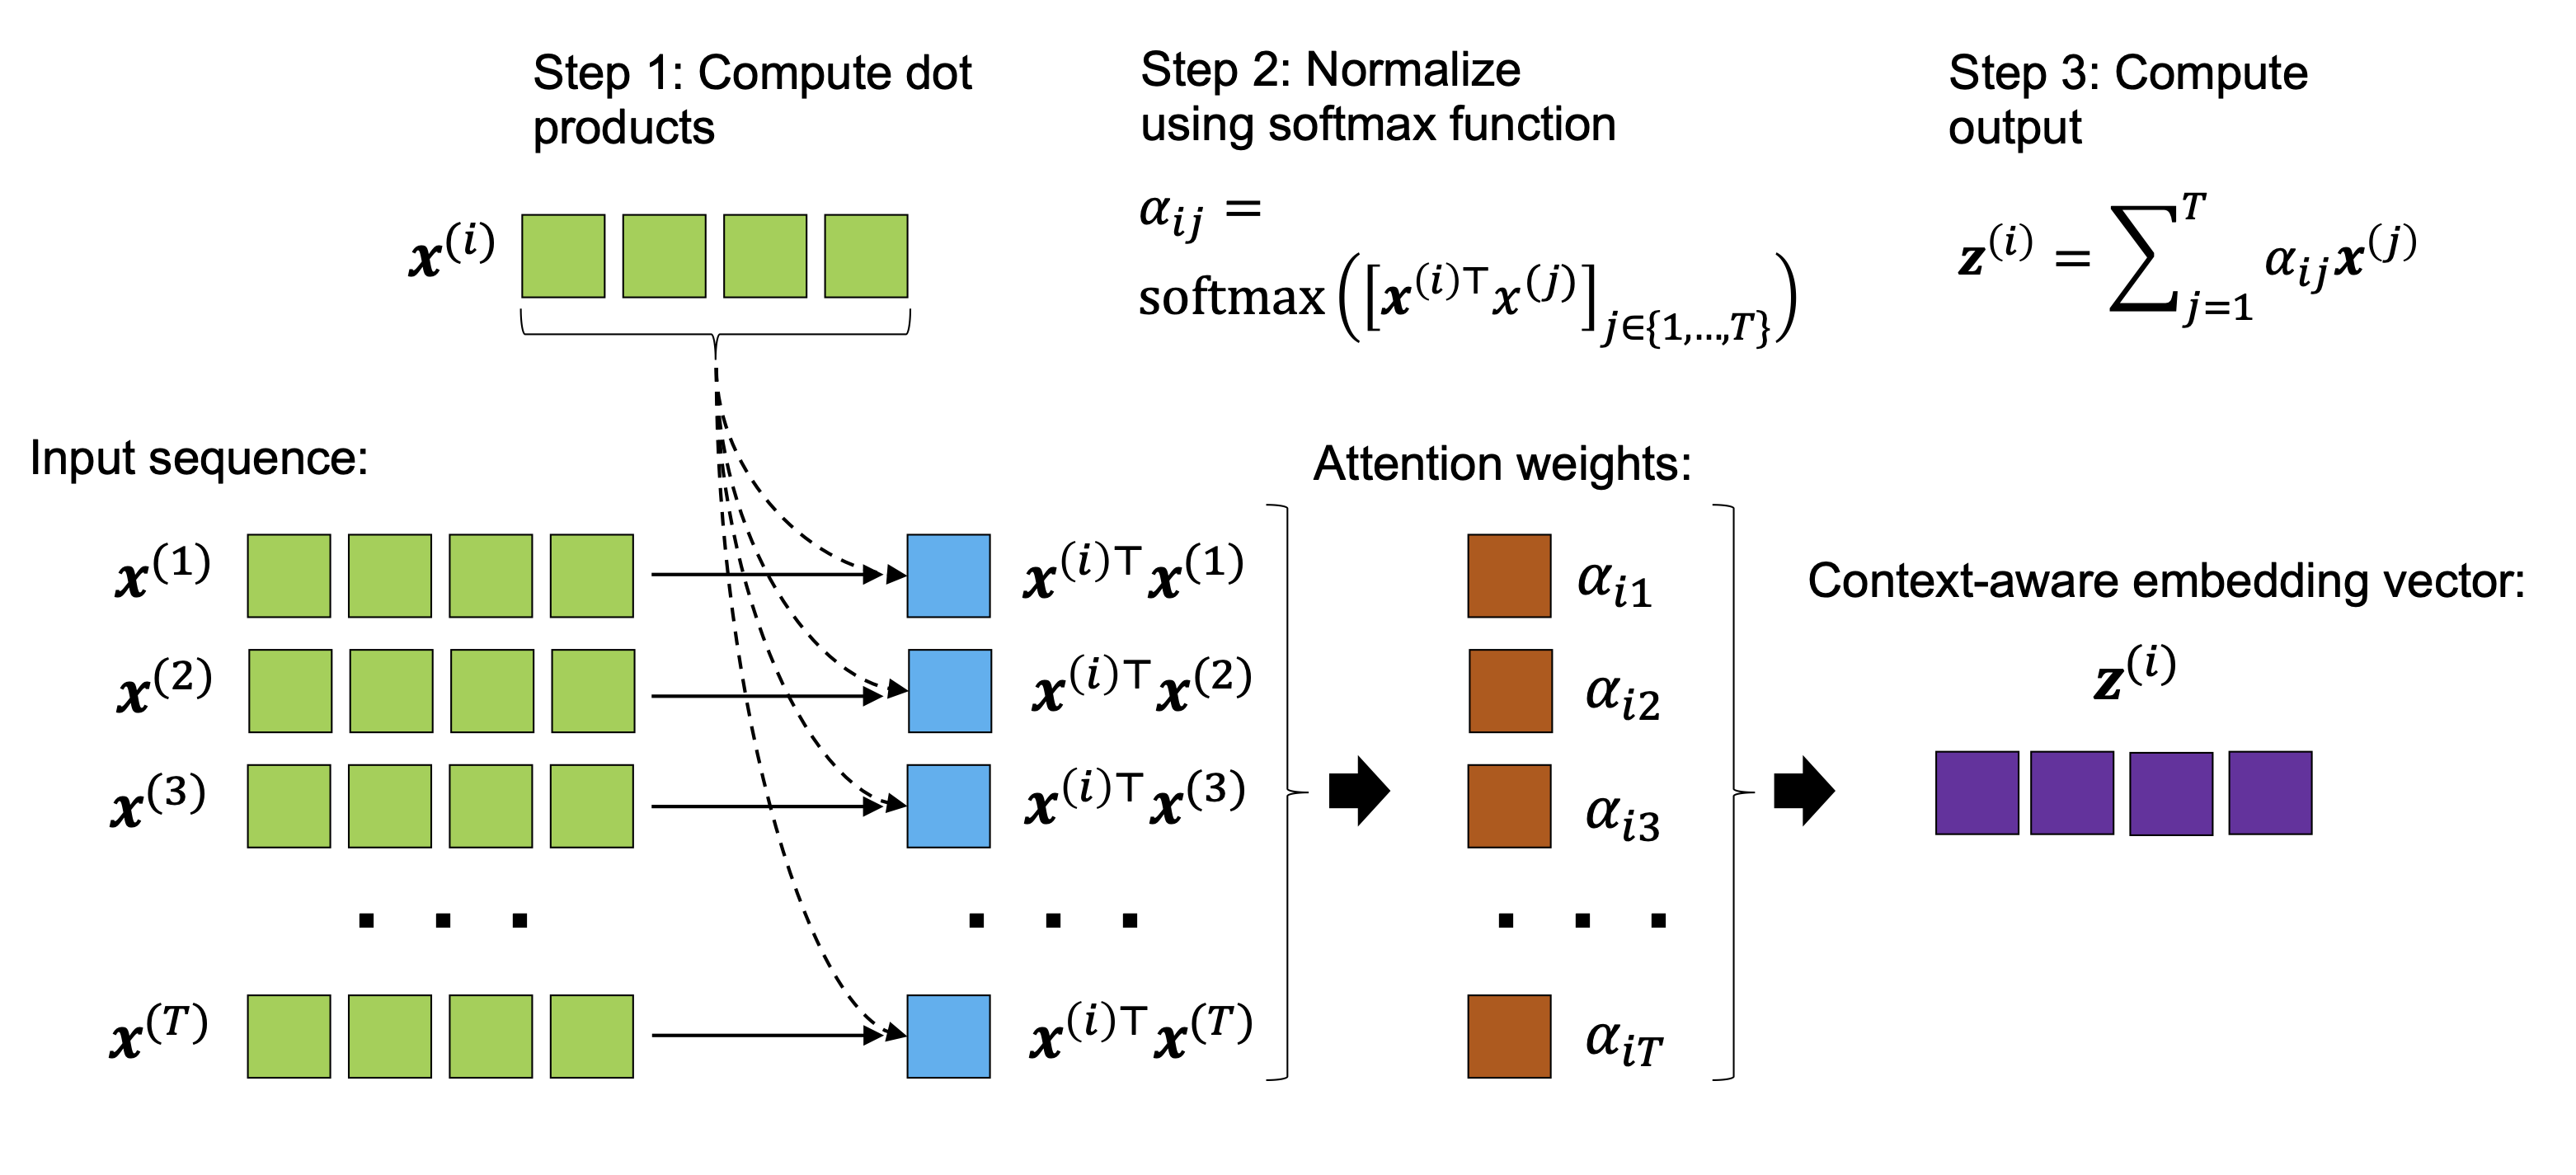

- 마지막으로 문맥 벡터를 입력의 어텐션 가중치 합으로 계산하는 코드 예제를 살펴보겠습니다(그림 16.4의 3단계)
- 특히 두 번째 입력 단어, 즉 ${𝒛}^{(2)}$에 대한 문맥 벡터를 계산한다고 가정해 보겠습니다.
- 앞서 어텐션 가중치를 얻었으므로 어텐션 가중치 $\alpha_{i j}$를 포함하는 문맥 벡터 $\boldsymbol{z}^{(i)}=\sum_{j=1}^{T} \alpha_{i j} \boldsymbol{x}^{(j)}$ 를 계산할 수 있습니다.
- 예를 들어, 두 번째 입력 요소(인덱스 1에 있는 요소)의 문맥 벡터를 계산하려면 다음과 같은 계산을 수행하면 됩니다:

In [ ]:
x_2 = embedded_sentence[1, :]
context_vec_2 = torch.zeros(x_2.shape)
for j in range(8):
    x_j = embedded_sentence[j, :]
    context_vec_2 += attention_weights[1, j] * x_j

context_vec_2

tensor([-9.3975e-01, -4.6856e-01,  1.0311e+00, -2.8192e-01,  4.9373e-01,
        -1.2896e-02, -2.7327e-01, -7.6358e-01,  1.3958e+00, -9.9543e-01,
        -7.1287e-04,  1.2449e+00, -7.8077e-02,  1.2765e+00, -1.4589e+00,
        -2.1601e+00])

In [ ]:
# 위에서 한번 이야기 했듯이, 행렬 곱셈을 사용하면 작업을 더 효율적으로 수행할 수 있습니다.
# 다음 코드를 사용하여 8개의 입력 단어 모두에 대한 컨텍스트 벡터를 계산합니다.

context_vectors = torch.matmul(attention_weights, embedded_sentence)

# embedded_sentence에 저장된 입력 단어 임베딩과 같이 context_vectors 행렬의 차원은 8 × 16입니다.
# 이 행렬의 두 번째 행에는 두 번째 입력 단어에 대한 컨텍스트 벡터가 포함되어 있으며, 다시 torch.allclose()를 사용하여 구현을 확인해보겠습니다.:

torch.allclose(context_vec_2, context_vectors[1])

True

- 보시다시피, 두 번째 컨텍스트 벡터의 루프 및 행렬 계산에 대한 매뉴얼은 동일한 결과를 산출했습니다.
- 기본 셀프 어텐션 구현은 이것으로 마치고
- 신경망 훈련 중에 사용할 수 있도록 최적화할 수 있는 학습 가능한 매개변수를 이용해 수정된 셀프 어텐션을 구현하도록 하겠습니다.

###  Parameterizing the self-attention mechanism: scaled dot-product attention

- 자! 드디어 진짜 트랜스포머 모델에 쓰이는 "학습 매개변수를 포함한" 셀프 어텐션 파트입니다.

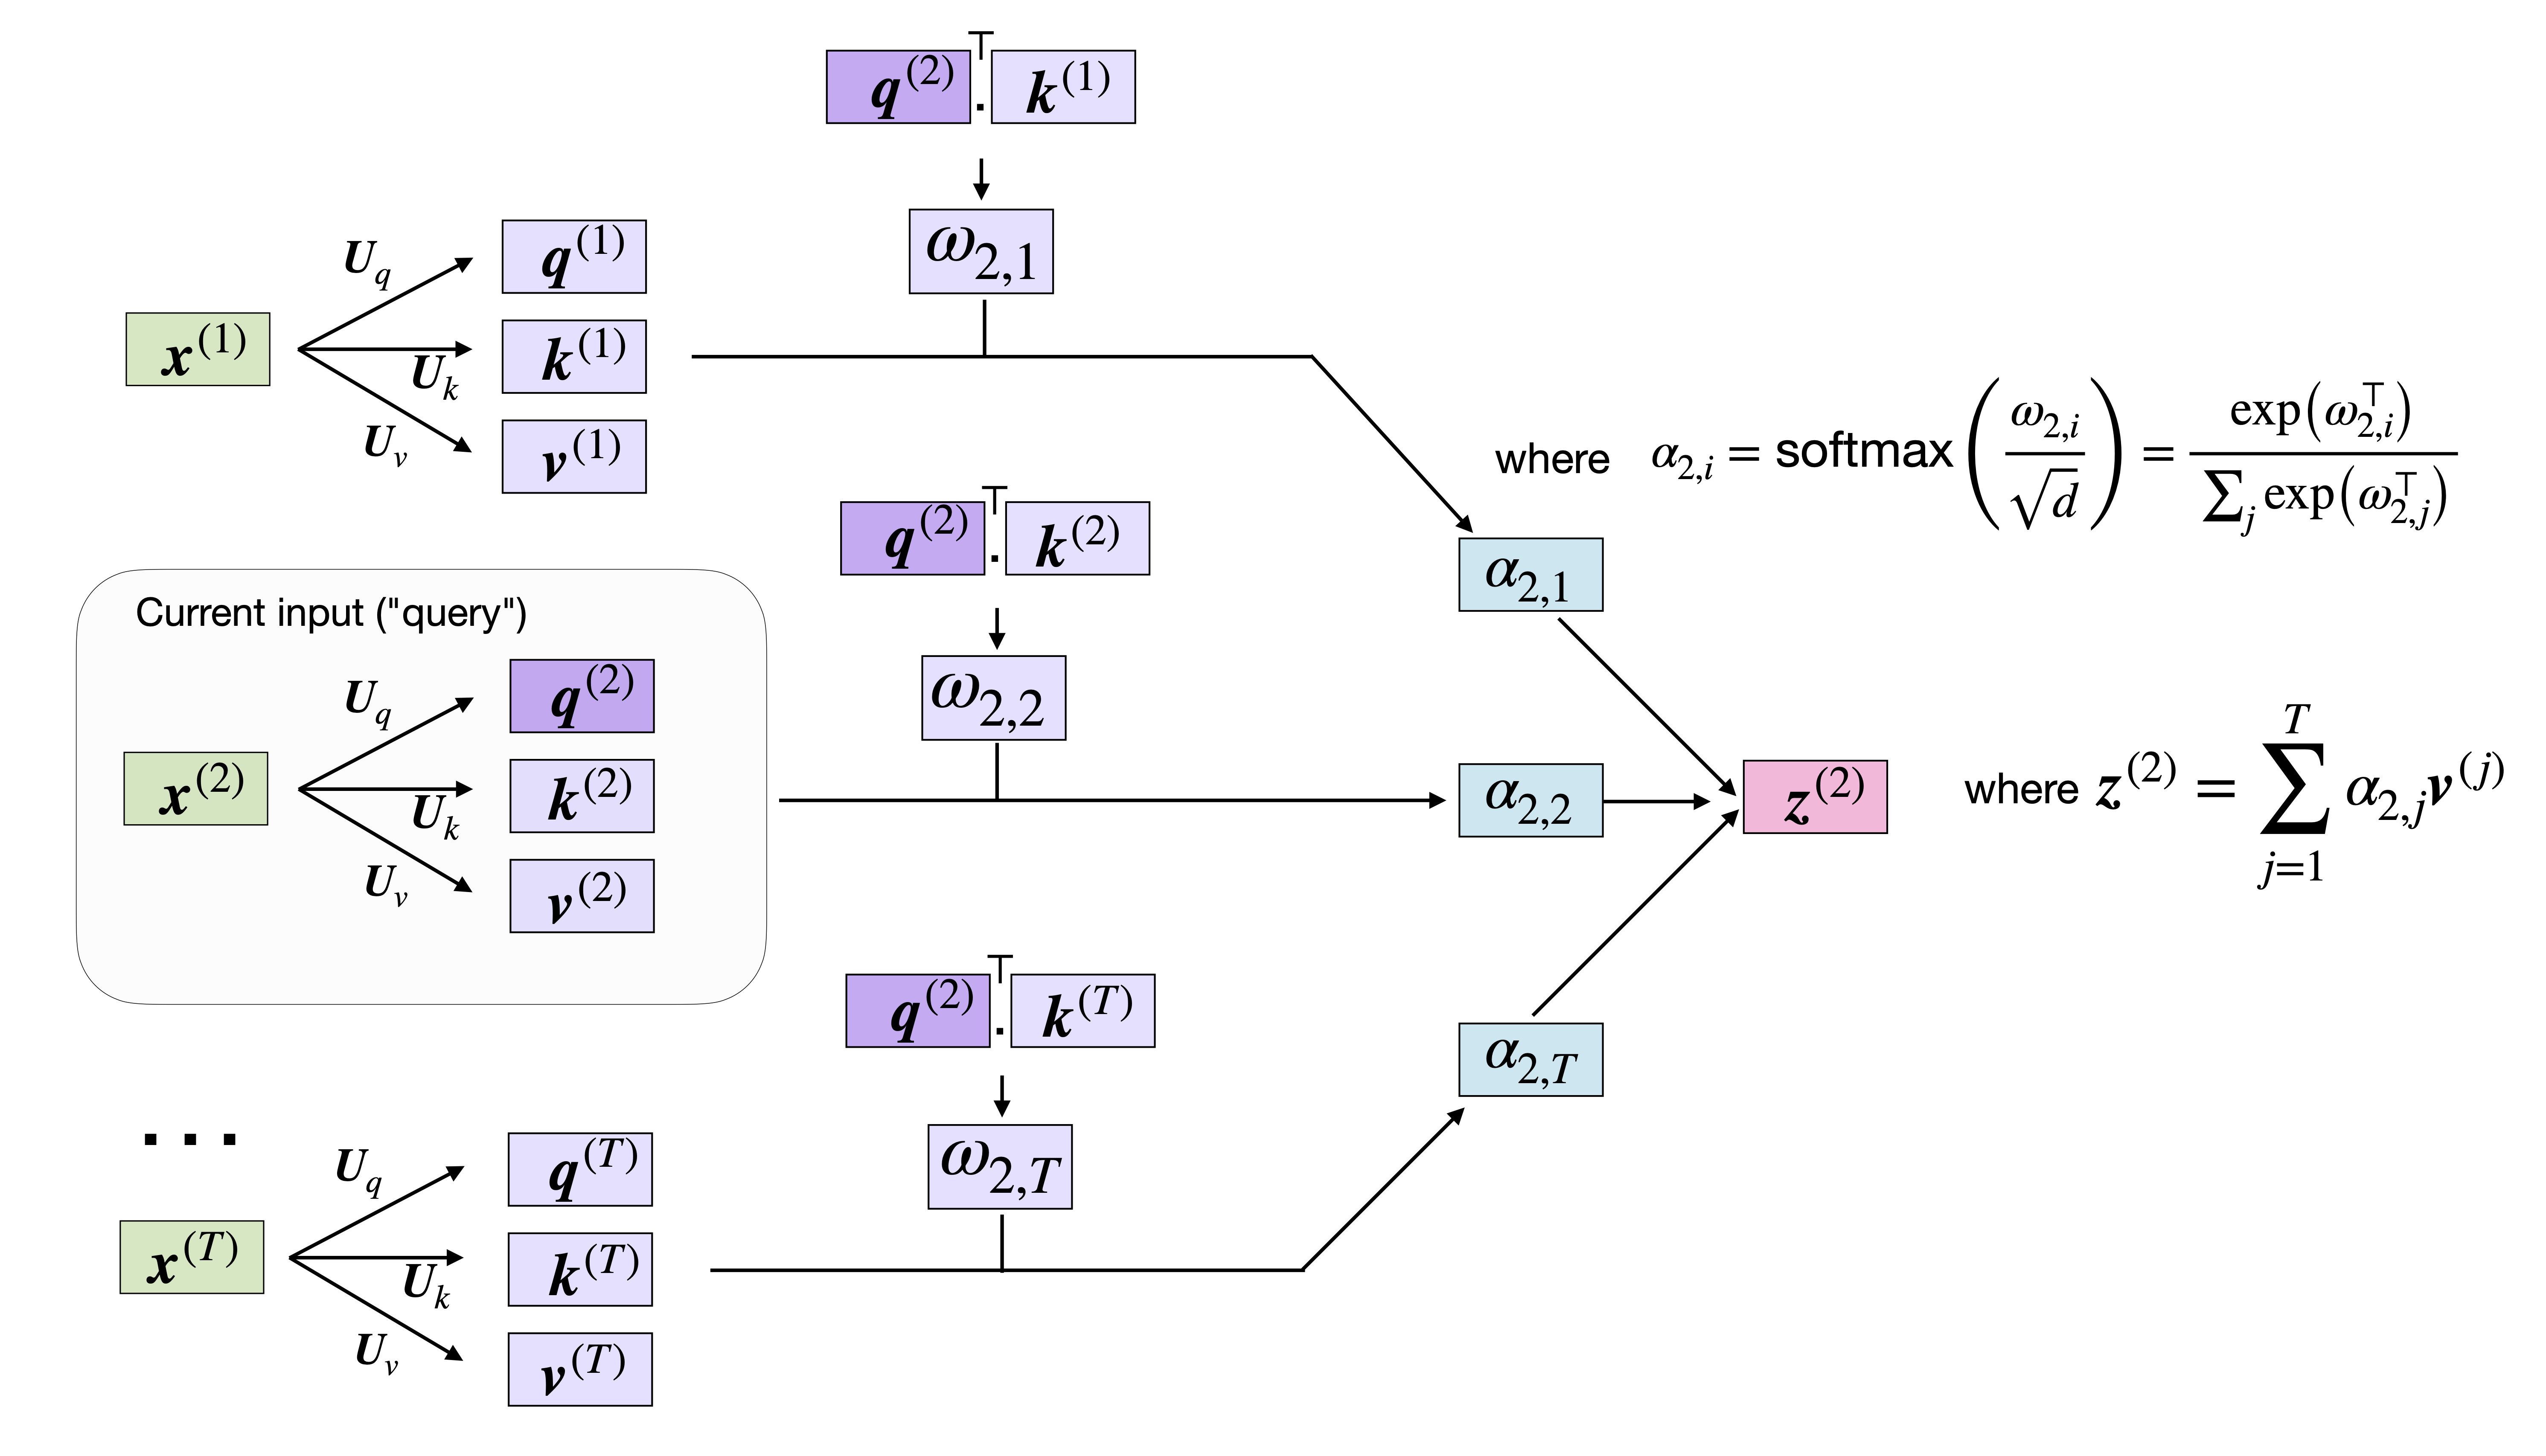

In [ ]:
# 코드를 통해 다음과 같이 투영 행렬을 초기화할 수 있습니다:

torch.manual_seed(123)

d = embedded_sentence.shape[1]
U_query = torch.rand(d, d)
U_key = torch.rand(d, d)
U_value = torch.rand(d, d)

- 쿼리 투영 행렬을 사용하여 쿼리 시퀀스를 계산할 수 있습니다.
- 이 예제에서는 두 번째 입력 요소인 ${𝒙}^{(𝑖)}$를 쿼리로 간주합니다:

In [ ]:
x_2 = embedded_sentence[1]
query_2 = U_query.matmul(x_2)

- 비슷한 방식으로 키와 값 시퀀스인 ${𝒌}^{(𝑖)}$와 ${𝒗}^{(𝑖)}$를 계산할 수 있습니다:

In [ ]:
key_2 = U_key.matmul(x_2)
value_2 = U_value.matmul(x_2)

- 하지만 다른 모든 입력 요소에 대한 키와 값 시퀀스도 필요하며, 이는 다음과 같이 계산할 수 있습니다:
- 키 행렬에서  i번째 행은 i번째 입력 요소의 키 시퀀스에 해당하며, 이는 값 행렬에도 동일하게 적용됩니다.
- 이를 확인하기 위해 torch.allclose()를 써서 확인합니다. (True를 반환해야 합니다!):

In [ ]:
keys = U_key.matmul(embedded_sentence.T).T
torch.allclose(key_2, keys[1])

True

In [ ]:
values = U_value.matmul(embedded_sentence.T).T
torch.allclose(value_2, values[1])

True

- 기본 셀프 어텐션에서는 정규화 되지 않은 원시 가중치를 계산할때 주어진 입력 시퀀스 행렬의  i 번째 단어 임베딩과 j 번째 단어 임베딩 사이의 도트 곱을 계산했었습니다.


$$\omega_{i j}=\boldsymbol{x}^{(i)^{\top}} \boldsymbol{x}^{(j)}$$


- 하지만 이제 이 매개변수화 된 셀프 어텐션 버전에서는 **쿼리**와 **키** 사이의 도트곱 연산을 수행하여 원시 가중치를 구합니다.


$$\omega_{i j}={q}^{(i)^{\top}} {k}^{(j)}$$

In [ ]:
# 아래 코드는 정규화되지 않은 관심도 가중치 𝜔23, 즉 쿼리와 세 번째(0,1,2) 입력 시퀀스 요소 사이의 도트 곱을 계산합니다:

omega_23 = query_2.dot(keys[2])
omega_23

tensor(14.3667)

In [ ]:
# 이 계산 역시 모든 키에 적용됩니다.

omega_2 = query_2.matmul(keys.T)
omega_2

tensor([-25.1623,   9.3602,  14.3667,  32.1482,  53.8976,  46.6626,  -1.2131,
        -32.9392])

In [ ]:
# 앞서 기본 셀프 어텐션에서도 했던 것처럼 문맥 벡터가 담긴 원시 가중치를 어텐션 가중치로 정규화합니다.
# 아래 코드는 이 정규화를 통해 전체 입력 시퀀스에 대해 관심도 가중치를 계산하는 코드입니다.

attention_weights_2 = F.softmax(omega_2 / d**0.5, dim=0)
attention_weights_2

tensor([2.2317e-09, 1.2499e-05, 4.3696e-05, 3.7242e-03, 8.5596e-01, 1.4026e-01,
        8.8897e-07, 3.1935e-10])

- 다만 약간 다른 점은 $√𝑚$를 사용하여 원시 가중치의 크기를 조정한 다음 소프트맥수 함수를 통해 정규화 한단 점입니다.
- 일반적으로 ${m}={d}^{k}$일 때 원시 가중치를 $√𝑚$로 스케일링하면 가중치 벡터의 유클리드 길이가 거의 같은 범위가 됩니다.


In [ ]:
#context_vector_2nd = torch.zeros(values[1, :].shape)
#for j in range(8):
#    context_vector_2nd += attention_weights_2[j] * values[j, :]

#context_vector_2nd

# 행렬 계산이 빠르나 반복문으로 이렇게 구현할 수도 있습니다.

- 마지막으로 시퀀스 값의 가중 평균을 구합니다.
- 수식은 다음과 같이 나타낼 수 있습니다. (기본 셀프 어텐션에서 보았던 가중합 수식을 같이 보시면 됩니다)

$${𝒛}^{(𝑖)}=\sum_{j=1}^{T} \alpha_{i j}\boldsymbol{v}^{(i)}$$

In [ ]:
context_vector_2 = attention_weights_2.matmul(values)
context_vector_2

tensor([-1.2226, -3.4387, -4.3928, -5.2125, -1.1249, -3.3041, -1.4316, -3.2765,
        -2.5114, -2.6105, -1.5793, -2.8433, -2.4142, -0.3998, -1.9917, -3.3499])

- 이것으로 각각의 어텐션 가중치가 부여된 모든 입력 요소를 포함시켜 문맥 인식 임베딩 벡터를 계산하는 고급 셀프 어텐션 구현을 마치겠습니다.
- 다음은 이 고급 셀프 어텐션이 이용된 트랜스포머 모델을 소개하겠습니다.

## Attention is all we need: 오리지널 트랜스포머 모델을 설명하기

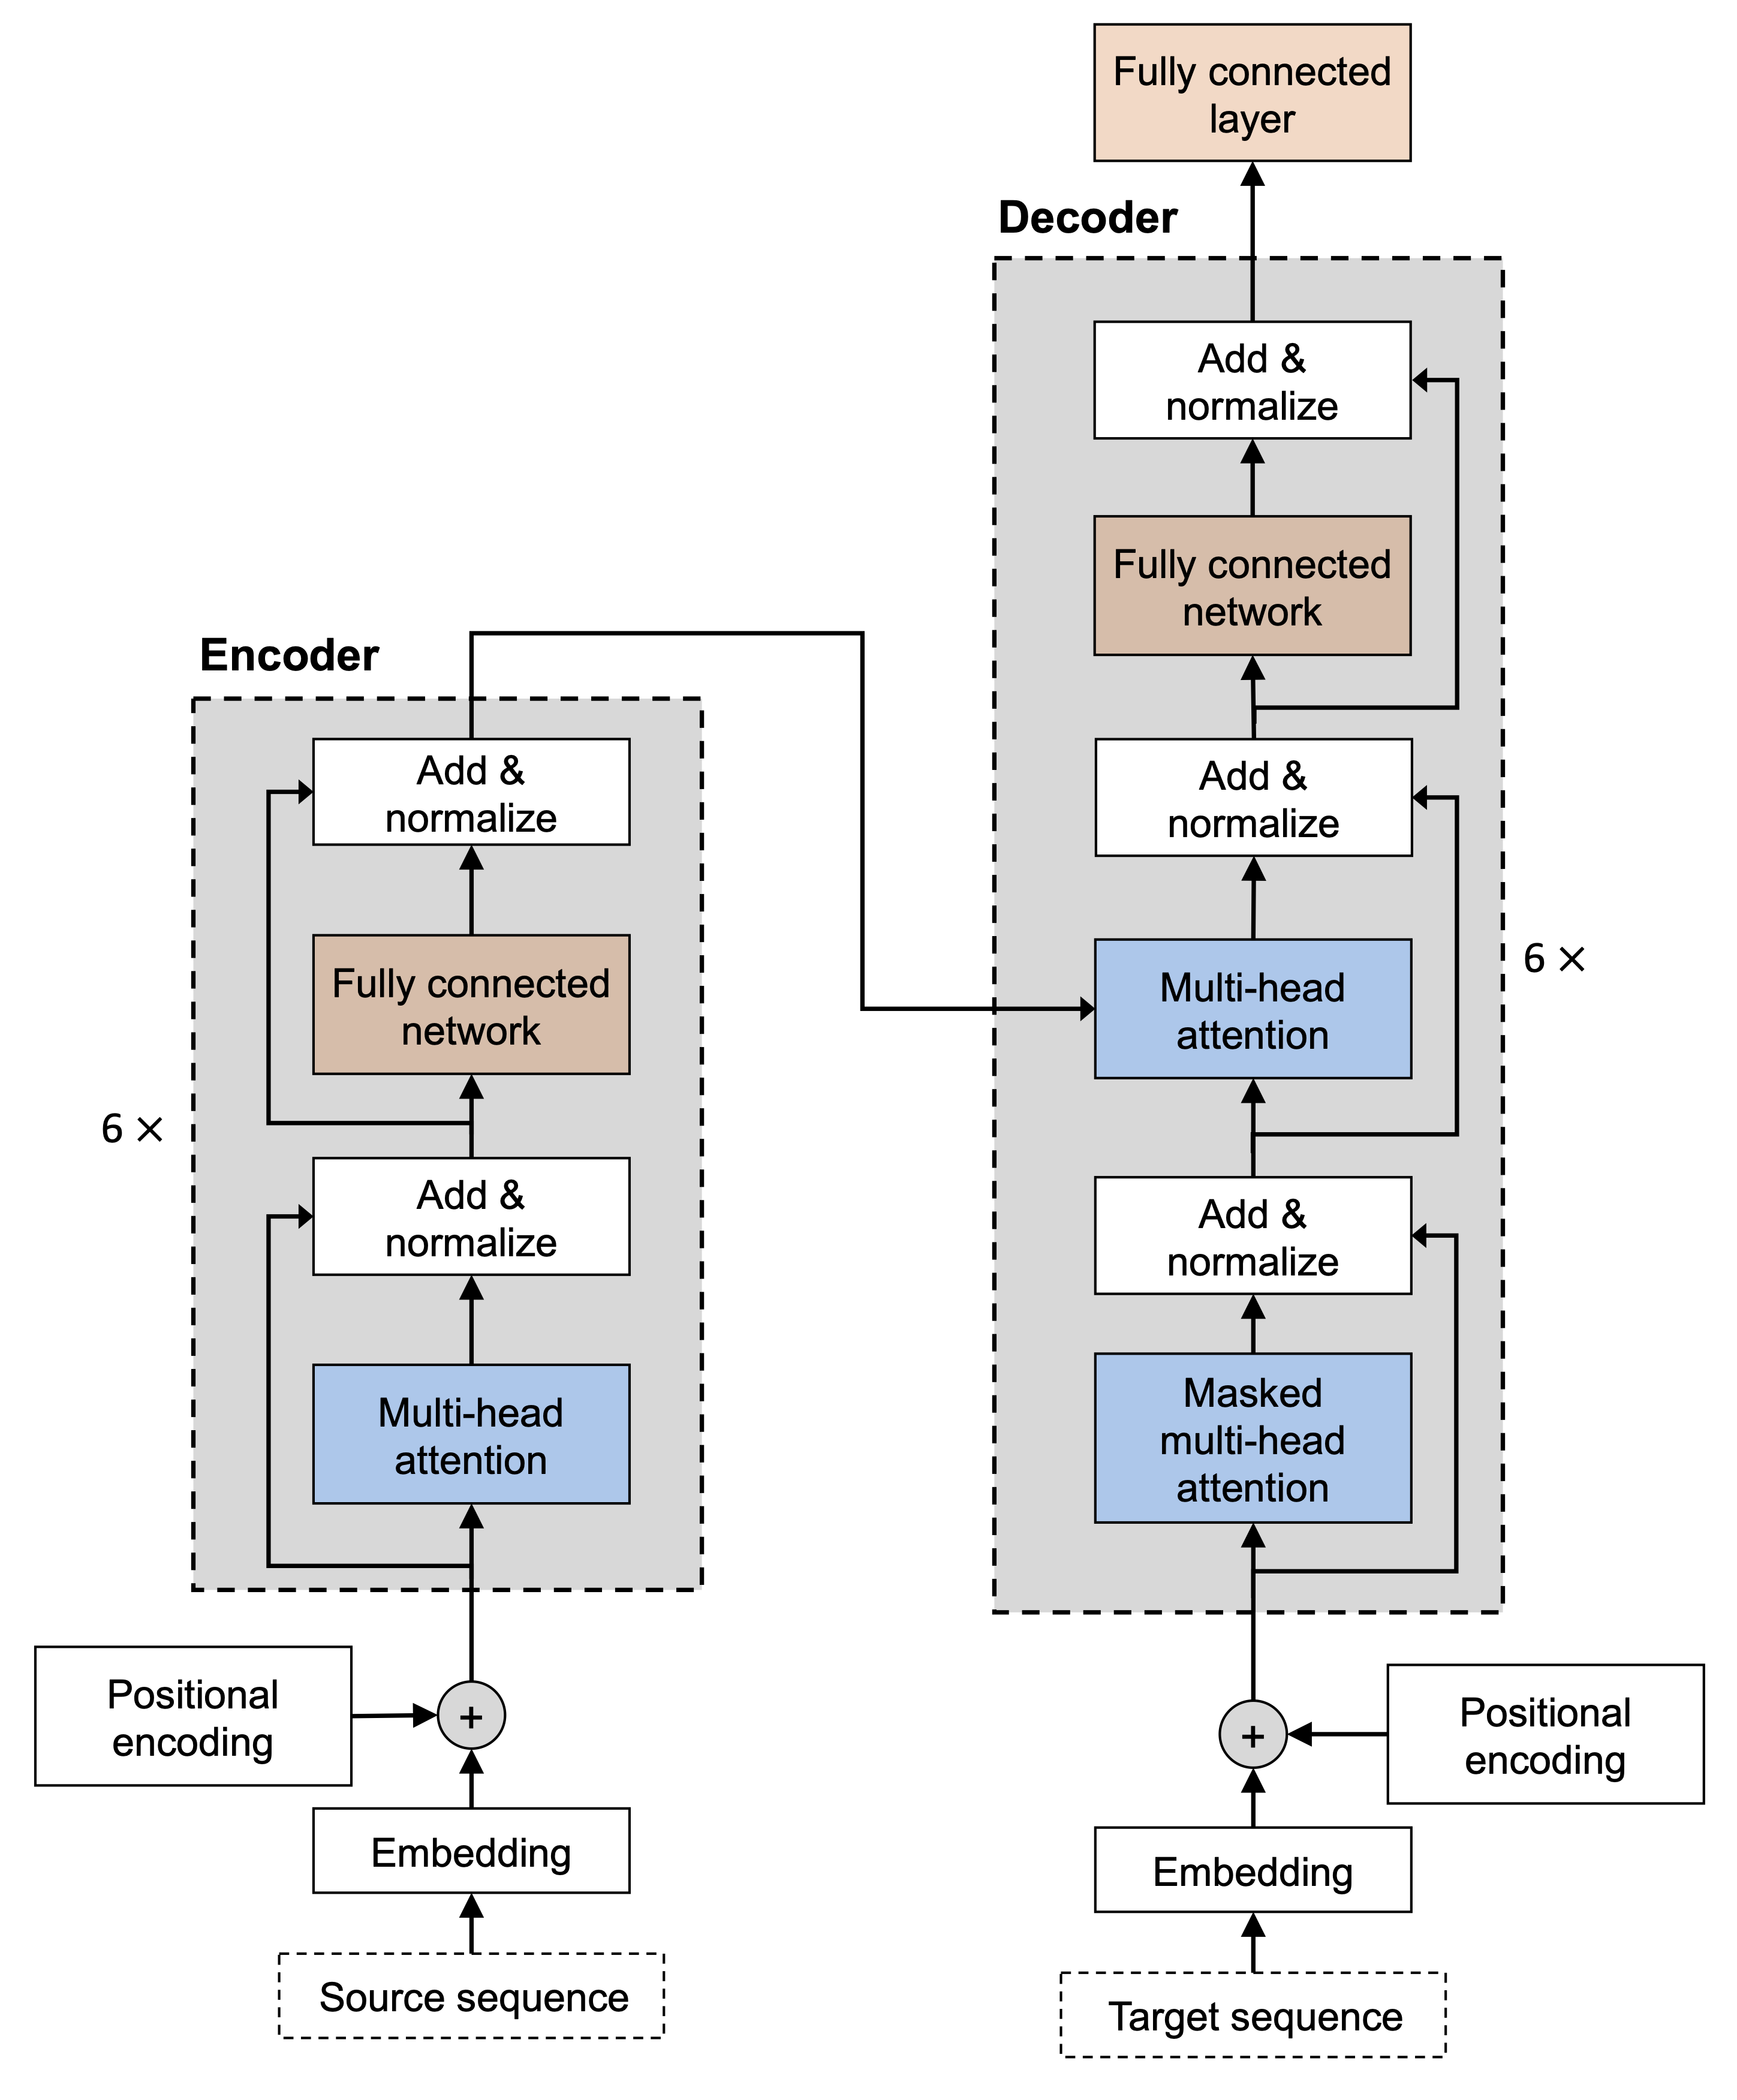

###  Encoding context embeddings via multi-head attention

- 멀티 헤드 셀프 어텐션 스택을 코드로 설명하려면 먼저 셀프 어텐션 메커니즘을 파라미터화를 해야합니다.
- 고급 셀프 어텐션 파트에서 단일 쿼리 투영 행렬을 만든 방법을 생각해 보세요:

In [ ]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]
one_U_query = torch.rand(d, d)

In [ ]:
# 이제 원래의 트랜스포머와 유사한 어텐션 헤드가 8개인 것으로 가정해 보겠습니다. (ℎ=8)

h = 8
multihead_U_query = torch.rand(h, d, d)
multihead_U_key = torch.rand(h, d, d)
multihead_U_value = torch.rand(h, d, d)

# 코드에서 볼 수 있듯이 차원을 추가하는 것만으로 여러 개의 관심 헤드를 추가할 수 있습니다.

# 잠깐!
- 실제로는 각 헤드마다 따로 매트릭스를 사용하는게 아니라 모든 어텐션 헤드에 대해 단일 매트릭스를 사용합니다. 다만 논리적으로 분리되어있습니다. 이 매트릭스는 Boolean Mask를 통해 접근할 수 있습니다.
- 따라서 여러개의 멀티플 어텐션 헤드로 데이터를 분할해도 여러 행렬 곱셈을 단일 행렬 곱셈으로 구현할 수 있게되며 (앞에서 누누이 강조했듯이 행렬연산이 더 빠르므로!) 효율적인 연산이 가능합니다.
- 하지만 이 챕터에서는 생략하도록 하겠습니다.

- 투영 행렬을 초기화한 후에는 도트 곱에서 수행되는 방식과 유사하게 투영된 시퀀스를 계산할 수 있습니다.
- 쿼리, 키, 값 시퀀스의 한 집합을 계산하는 대신 시퀀스들의 h 집합을 계산합니다.
- 아래 코드와 같이 j번째 헤드의 i번째 데이터 포인트에 대한 쿼리 투영과 관련된 계산은 다음과 같이 작성할 수 있습니다

$${q}^{(i)}_{j}={U}_{q_j} {x}^{(j)}$$

In [ ]:
multihead_query_2 = multihead_U_query.matmul(x_2)
multihead_query_2.shape

torch.Size([8, 16])

In [ ]:
multihead_key_2 = multihead_U_key.matmul(x_2)
multihead_value_2 = multihead_U_value.matmul(x_2)

In [ ]:
# 모든 헤드에 대해 이 계산을 반복합니다.
# 코드는 쿼리로 두번째 입력된 단어에 대해서 다음과 같이 표시됩니다.

multihead_key_2[2]

# multihead_query_2 행렬에는 8개의 행이 있으며, 각 행은 j번째 주의 헤드에 해당합니다.마찬가지로 각 헤드에 대한 키 및 값 시퀀스를 계산할 수 있습니다:

tensor([-1.9619, -0.7701, -0.7280, -1.6840, -1.0801, -1.6778,  0.6763,  0.6547,
         1.4445, -2.7016, -1.1364, -1.1204, -2.4430, -0.5982, -0.8292, -1.4401])

In [ ]:
#요소에 대해 키와 값 계산을 반복합니다. 나중에 자체 어텐션 점수를 계산할 때 필요합니다.
#가장 간단한 방법은 입력 시퀀스 임베딩을 첫 번째 차원으로 크기 8로 확장하면 됩니다. 이를 위해 .repeat() 메서드를 사용합니다:

stacked_inputs = embedded_sentence.T.repeat(8, 1, 1)
stacked_inputs.shape

torch.Size([8, 16, 8])

In [ ]:
# 그런 다음 모든 키를 계산하기 위해 주의 헤드를 사용하여 torch.bmm()을 통해 일괄 행렬 곱셈을 할 수 있습니다

multihead_keys = torch.bmm(multihead_U_key, stacked_inputs)
multihead_keys.shape

torch.Size([8, 16, 8])

- 이 코드에서는 이제 첫 번째 차원에서 8개의 어텐샨 헤드를 참조하는 텐서를 갖게 되었습니다.
- 두 번째와 세 번째 차원은 각각 임베딩 크기와 단어 수를 나타냅니다.

In [ ]:
# 키가 보다 직관적으로 표현되도록, 두 번째와 세 번째 차원을 바꾸어 보겠습니다.( 원래 입력 시퀀스 embedded_sentence와 동일한 차원을 갖도록 )

multihead_keys = multihead_keys.permute(0, 2, 1)
multihead_keys.shape

torch.Size([8, 8, 16])

In [ ]:
# 재배치 후, 다음과 같이 두 번째 주의 헤드의 두 번째 키 값에 액세스할 수 있습니다:

multihead_keys[2, 1] # index: [2nd attention head, 2nd key]

# 이 값은 앞서 multihead_key_2[2]를 통해 얻은 것과 동일한 키 값이며, 이는 우리의 복잡한 행렬 조작과 계산이 정확하다는 것을 나타냅니다.

tensor([-1.9619, -0.7701, -0.7280, -1.6840, -1.0801, -1.6778,  0.6763,  0.6547,
         1.4445, -2.7016, -1.1364, -1.1204, -2.4430, -0.5982, -0.8292, -1.4401])

In [ ]:
# 이제 값 시퀀스에 대해 이 과정을 반복해 보겠습니다:

multihead_values = torch.matmul(multihead_U_value, stacked_inputs)
multihead_values = multihead_values.permute(0, 2, 1)

In [ ]:
# 단일 헤드 어텐션 계산 단계에 따라 문맥 벡터를 계산합니다.
# 간결성을 위해 중간 단계는 생략하고 두 번째 입력 요소인 쿼리와 8개의 서로 다른 주의 헤드에 대한 문맥 벡터를 무작위 데이터를 통해 multihead_z_2로 표시하여 계산했다고 가정해 보겠습니다:

multihead_z_2 = torch.rand(8, 16)

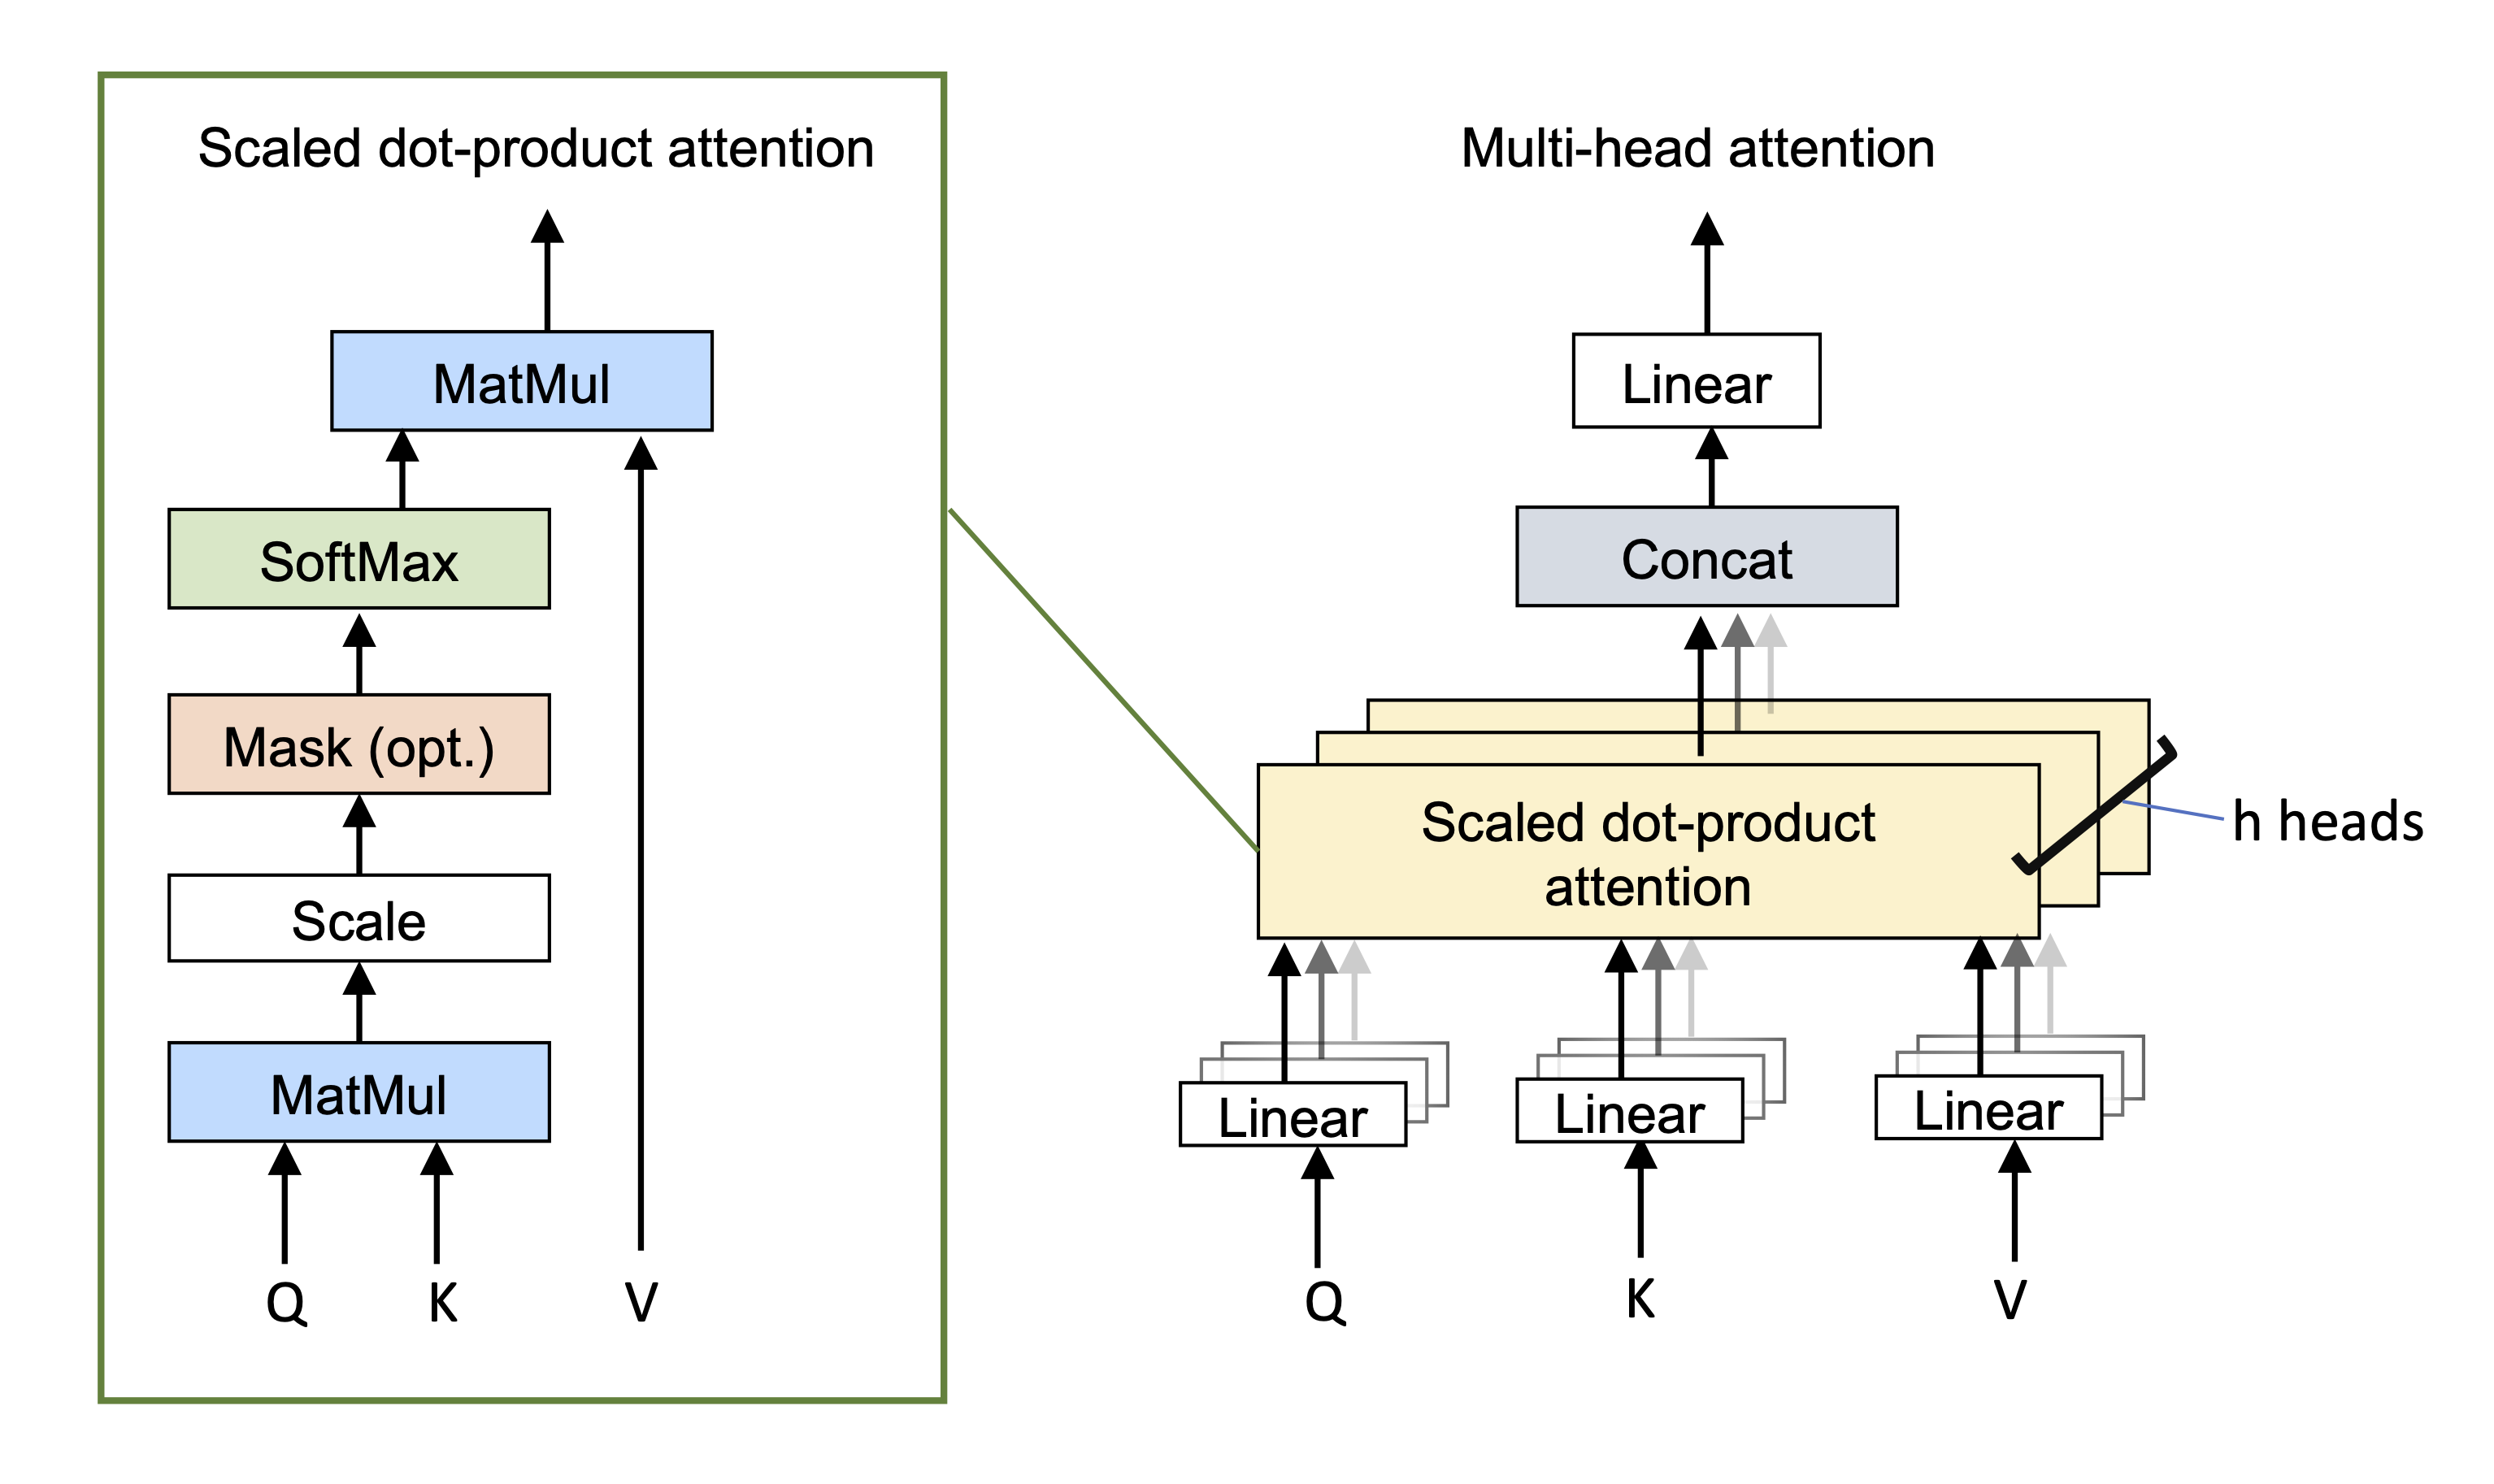

In [ ]:
# 첫 번째 차원은 8개의 어텐션 헤드를 인덱싱하고, 문맥 벡터는 입력 문장과 마찬가지로 16차원 벡터입니다
# 8개의 어텐션 헤드에 대해 각각 두번째 입력 요소에 대한 것이 하나씩 있다고 생각하시면 됩니다!

linear = torch.nn.Linear(8*16, 16)

# 그런 다음 이러한 벡터를 길이 𝑑𝑣 × ℎ의 하나의 긴 벡터로 연결하고 완전히 연결된 레이어를 통해 길이 𝑑𝑣의 벡터로 다시 매핑합니다

context_vector_2 = linear(multihead_z_2.flatten())
context_vector_2.shape

torch.Size([16])

# 모델 소개와 맛보기

## Using GPT-2 to generate new text


In [ ]:
# pip install transformers==4.9.1 이상인 것이 좋습니다.
# 트랜스포머 라이브러리를 설치했으면 다음 코드를 실행하여 새 텍스트를 생성할 수 있는 사전 학습된 GPT 모델을 가져올 수 있습니다.

from transformers import pipeline, set_seed


generator = pipeline('text-generation', model='gpt2')
set_seed(123)
generator("Hey readers, today is",
          max_length=20,
          num_return_sequences=3)

# 그런 다음 모델에 텍스트 스니펫을 입력하고 해당 입력 스니펫을 기반으로 새 텍스트를 생성하도록 요청할 수 있습니다:
# 결과에서 볼 수 있듯이, 모델은 텍스트 스니펫을 기반으로 세 개의 문장을 생성했습니다.
#더 많은 예시를 살펴보고 싶다면 "무작위 시드와 최대 시퀀스 길이"를 자유롭게 변경해 보세요.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hey readers, today is the third day in a row where I am starting to get a little fed'},
 {'generated_text': 'Hey readers, today is a very important weekend, and thanks to all of you, will be a'},
 {'generated_text': 'Hey readers, today is the third day of the New Year after I posted a series on the Internet'}]

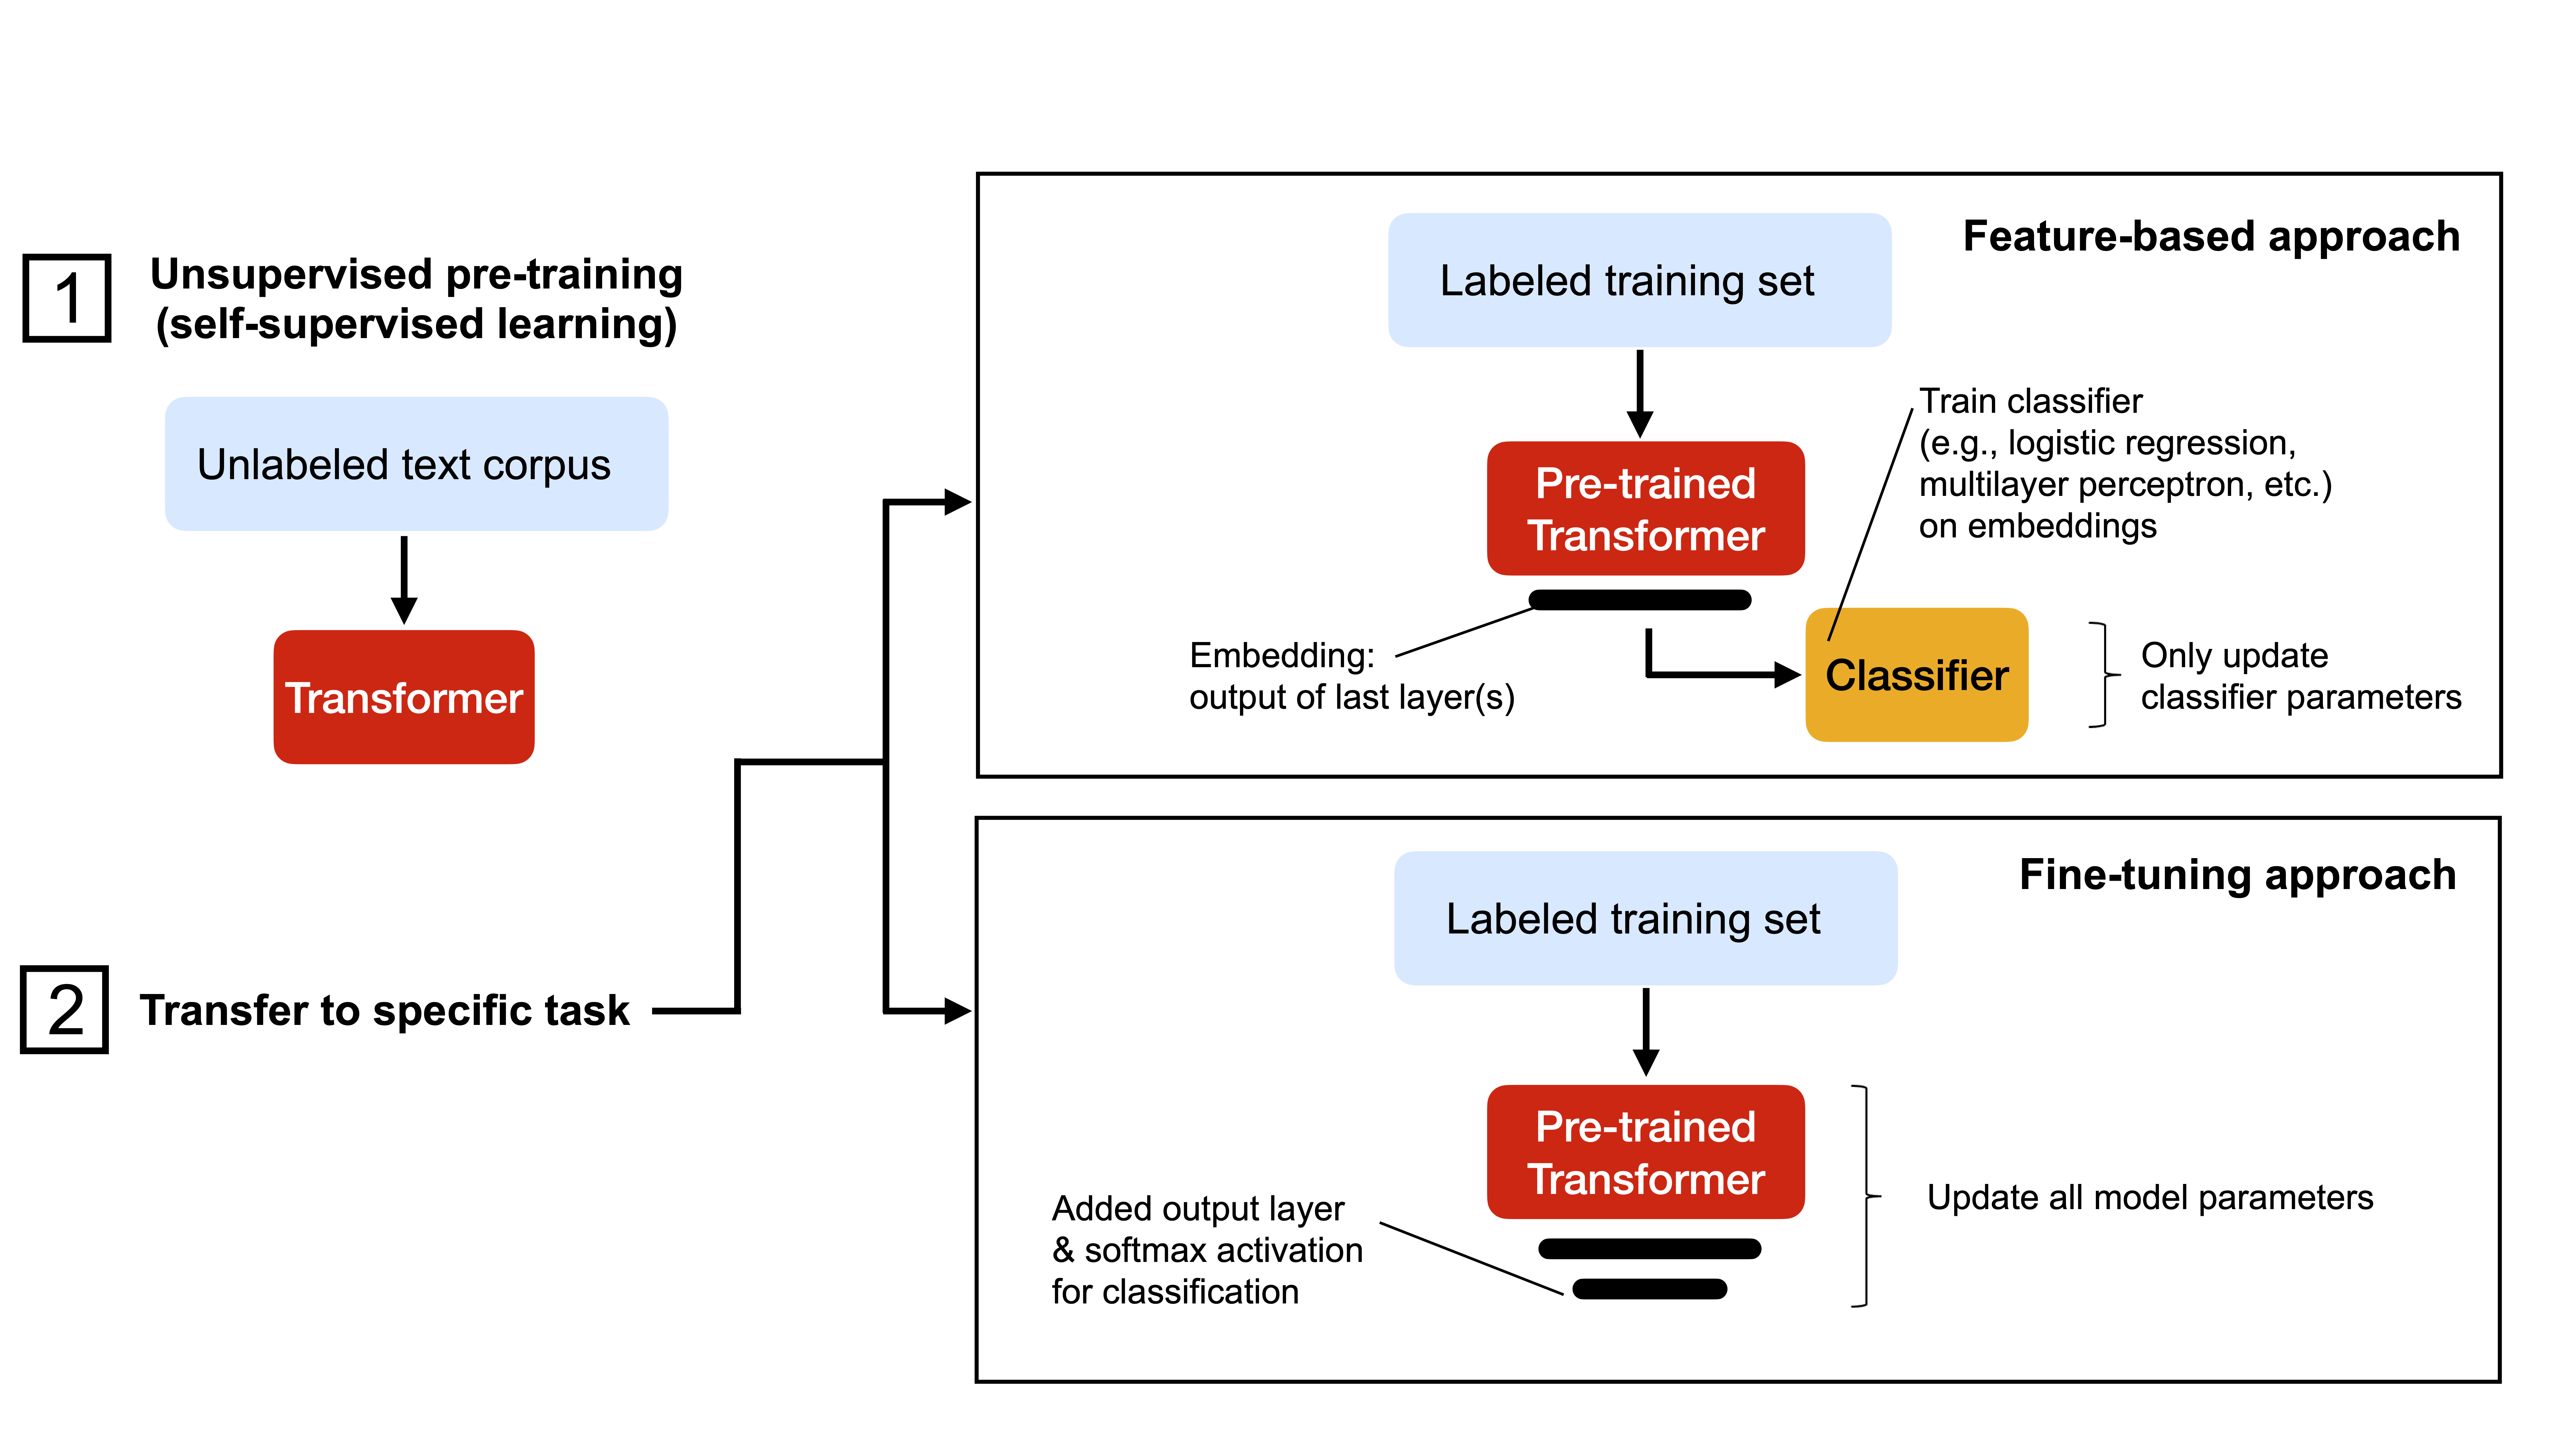

In [ ]:
# 위와 같이 다른 모델을 훈련하기 위한 특징을 생성하기 위해서 사용할 수도 있습니다.

from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
text = "Let us encode this sentence"
encoded_input = tokenizer(text, return_tensors='pt')
encoded_input

# 입력 문장의 텍스트를 GPT-2 모델을 위해 토큰화된 형식으로 인코딩했습니다.
#보시다시피 문자열을 정수 표현으로 매핑하고 주의 마스크를 모두 1로 설정했는데, 이는 여기에 표시된 것처럼 인코딩된 입력을 모델에 전달할 때 모든 단어가 처리된다는 것을 의미합니다:

{'input_ids': tensor([[ 5756,   514, 37773,   428,  6827]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [ ]:
from transformers import GPT2Model
model = GPT2Model.from_pretrained('gpt2')

In [ ]:
output = model(**encoded_input)
output['last_hidden_state'].shape

# 출력 변수에는 마지막 숨겨진 상태, 즉 입력 문장의 GPT-2 기반 특징 인코딩이 저장됩니다:

torch.Size([1, 5, 768])

- 너무 거추장스러운 출력은 빼고 텐서의 모양만 표시했습니다.
- 텐서의 첫 번째 차원은 배치 크기고(입력 텍스트가 하나만 있음), 그 다음이 문장 길이와 특징 인코딩의 크기입니다.
- 여기서는 다섯 단어 각각이 768차원 벡터로 인코딩됩니다.

# **Fine-tuning a BERT model in PyTorch**

## **IMDb 영화 리뷰 데이터셋 불러오기**

In [ ]:
import gzip
import shutil
import time

import pandas as pd
import requests
import torch
import torch.nn.functional as F
import torchtext

import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

In [ ]:
# 세팅하기

torch.backends.cudnn.deterministic = True
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NUM_EPOCHS = 3

In [ ]:
# 데이터셋 다운로드하기

url = "https://github.com/rasbt/machine-learning-book/raw/main/ch08/movie_data.csv.gz"
filename = url.split("/")[-1]

with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

with gzip.open('movie_data.csv.gz', 'rb') as f_in:
    with open('movie_data.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
# 데이터셋 확인하기

df = pd.read_csv('movie_data.csv')
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [ ]:
# 데이터 크기 및 구조 확인하기

df.shape

(50000, 2)

In [ ]:
# 훈련데이터와 테스트 데이터로 나누기

train_texts = df.iloc[:35000]['review'].values
train_labels = df.iloc[:35000]['sentiment'].values

valid_texts = df.iloc[35000:40000]['review'].values
valid_labels = df.iloc[35000:40000]['sentiment'].values

test_texts = df.iloc[40000:]['review'].values
test_labels = df.iloc[40000:]['sentiment'].values

## 가지고온 데이터 셋을 토큰화 하기! (언어 모델이므로 언어모델에 사용할 수 있게)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

In [ ]:
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
# 데이터 셋 클래스 정의하기 -> 사용하기 편하게!

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = IMDbDataset(train_encodings, train_labels)
valid_dataset = IMDbDataset(valid_encodings, valid_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

## pre-trained BERT model을 불러오고 파인 튜닝하기
 - 파인 튜닝이란, 사전 학습 모델(pre-trained model)에 도메인 특화 데이터를 추가 학습시켜 맞춤형 모델로 업데이트 하는 것

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(DEVICE)
model.train()

optim = torch.optim.Adam(model.parameters(), lr=5e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

        ### Prepare data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

        return correct_pred.float()/num_examples * 100

In [ ]:
start_time = time.time()

## 코랩에서는 메모리 부족(12GB 초과)으로 세션이 터집니다! 코랩말고 넉넉한 공간에서 구동하세요.

for epoch in range(NUM_EPOCHS):

    model.train()

    for batch_idx, batch in enumerate(train_loader):

        ### 데이터 준비
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        ### 순방향
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']

        ### 역방향
        optim.zero_grad()
        loss.backward()
        optim.step()

        ### 출력하기...(로깅)
        if not batch_idx % 250:
            print (f'Epoch: {epoch+1:04d}/{NUM_EPOCHS:04d} | '
                   f'Batch {batch_idx:04d}/{len(train_loader):04d} | '
                   f'Loss: {loss:.4f}')

    model.eval()

    with torch.set_grad_enabled(False):
        print(f'Training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nValid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')

In [ ]:
del model

# 한번 해봤으니 메모리를 위해 지웁니다~~~

## 트레이너 API를 사용하여 더욱 편리하게 트랜스포머 미세 조정하기

In [ ]:
#사전 학습 모델 다시 불러오기

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(DEVICE)
model.train();

In [ ]:
from transformers import Trainer, TrainingArguments

## accelerate>=0.20.1 버전 이상이 필요합니다. 안될 경우 #pip install accelerate -U


optim = torch.optim.Adam(model.parameters(), lr=5e-5)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

In [ ]:
# pip install datasets을 이용해서 설치하세요!!!!

from datasets import load_metric
import numpy as np


metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred # 로지스틱은 파이토치 텐서가 아니고 그냥 어레이입니다.
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(
               predictions=predictions, references=labels)

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=5e-5)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10
)

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optim, None) # 옵티마이저와 러닝레이트 조절하기
)

# 모델이 1개의 GPU만 사용하도록 강제 설정 해주세요(여러 개를 사용할 수 있는 경우에도)
# 이전 코드와 더 공정하게 비교하기 위해서 입니다.

trainer.args._n_gpu = 1

In [ ]:
start_time = time.time()
trainer.train()
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

In [ ]:
trainer.evaluate()

In [ ]:
model.eval()
model.to(DEVICE)
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')